In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax
import optax

# Set random seed for reproducibility
np.random.seed(420)

# Load feature matrix (X) and target variable (y) from .npy files
X = np.load("C:/Users/piyus/OneDrive/Piyush_Personal/Piyush/Financial Engineering/Courses/Self projects/Fundamental Forecasts/X.npy")
y = np.load("C:/Users/piyus/OneDrive/Piyush_Personal/Piyush/Financial Engineering/Courses/Self projects/Fundamental Forecasts/y.npy")

# Split data into train, validation, and test sets
i = int(0.8*len(X))  # Index for 80% of data (train set end)
j = int(0.9*len(X))  # Index for 90% of data (validation set end)

# Shuffle the data randomly
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

# Create train, validation, and test sets
x_train, y_train = X[:i], y[:i]  # 80% for training
x_val, y_val = X[i:j], y[i:j]    # 10% for validation
x_test, y_test = X[j:], y[j:]    # 10% for testing

In [29]:
# Define the penalty function for regularization
def penalty(θ, λ, X):
    """
    Calculate the L2 regularization penalty.
    
    Args:
    θ (array): Model parameters
    λ (float): Regularization strength
    X (array): Input features (not used in this implementation, but kept for consistency)
    
    Returns:
    float: The L2 penalty term
    """
    return λ / 2 * jnp.sum(θ**2)

# Define hyperparameter lists for grid search
# Learning rates
α_list = [0.1, 0.05, 0.01, 1e-3, 1e-4, 1e-6]

# Beta values for momentum (Adam optimizer)
beta_list = [0, 0.2, 0.5, 0.9, 0.99, 0.999]

# Beta2 values for adaptive learning rate (Adam optimizer)
beta2_list = [0, 0.2, 0.5, 0.9, 0.99, 0.999]

# Regularization strengths
λ_list = [0.01, 0.1, 0.2, 0.5]

# Batch sizes for mini-batch gradient descent
batch_size_list = [10, 20, 50, 100]

# Number of models to ensemble
n_model_list = [1, 10, 20, 50]

In [43]:
def stack(Θ):
  return jnp.array([Θ] * n_model)


def mse(a, b):
  return ((a - b)**2).mean()

def plot(x, y):
  i = min(min(x),min(y))
  j = max(max(x),max(y))
  i2 = np.linspace(i, j, len(x))
  j2 = i2
  plt.scatter(x,y)
  plt.plot(i2,j2,color = "red")
  plt.xlabel('Prediction')
  plt.ylabel('y')
  plt.legend()
  plt.show()

@jax.jit
@jax.vmap
def evaluate(Θ):
    return mse(x_val @ Θ, y_val)

def test(Θ):
    return mse(x_test @ Θ, y_test)

def update(Θ, opt_state, X, y, α, β, β2, λ):
  def L(Θ, X, y):
    predict = X @ Θ
    return mse(predict, y) + λ * Θ @ Θ

  grad = jax.grad(L)(Θ, X, y)

  optmizer = optax.adam(α, β, β2)
  updates, opt_state = optmizer.update(grad, opt_state)
  Θ = optax.apply_updates(Θ, updates)
  return Θ, opt_state

update = jax.jit(jax.vmap(update, in_axes=(0, 0, None, None, 0, 0, 0, 0)))

def sample(batch_size):
  idx = np.random.choice(len(x_train), batch_size)
  return x_train[idx], y_train[idx]

In [45]:
θ2 = []
for batch_size in batch_size_list:
  for n_model in n_model_list:
    n_features = x_train.shape[1]
    α_vec = np.random.choice(α_list, n_model)
    β_vec = np.random.choice(beta_list, n_model)
    β2_vec = np.random.choice(beta2_list, n_model)
    λ_vec = np.random.choice(λ_list, n_model)

    # optmizer = optax.adam(0.01, 0.99, 0.9)
    optmizer = optax.adam(α_vec[0], β_vec[0], β2_vec[0])
    Θ = jnp.zeros(n_features)
    opt_state = optmizer.init(Θ)

    Θ = stack(Θ)
    opt_state = jax.tree.map(stack, opt_state)

    #opt_state = jax.tree(lambda s: stack(s, n_model), opt_state)
    # opt_state = jax.tree_util.tree_map(lambda s: stack(s, 20), opt_state) #tree_util <- tree


    for iteration in range(5000):
      Xi, yi = sample(batch_size)

      Θ, opt_state = update(Θ, opt_state, Xi, yi, α_vec, β_vec, β2_vec, λ_vec)
    # Best model choice
    idx_best = jnp.argmin(evaluate(Θ))
    θ_dic = {
        "α": α_vec[idx_best],
        "λ": λ_vec[idx_best],
        "β": β_vec[idx_best],
        "β2": β2_vec[idx_best],
        "batch_size": batch_size,
        "n_model": n_model,
        "MSE": evaluate(Θ)[idx_best],
        "Θ": Θ[idx_best]
    }
    θ2.append(θ_dic)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.29942402


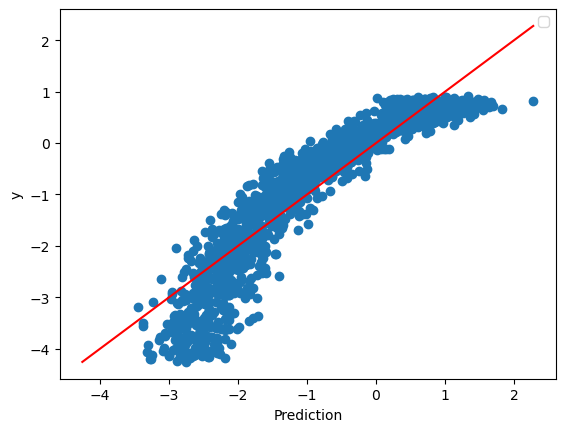

In [49]:
# Test the best model on the test set
MSE_test = test(best_model['Θ'])
print(MSE_test)  # Print the Mean Squared Error on the test set

# Generate predictions using the best model
pred = x_test @ best_model['Θ']

# Visualize the predictions vs actual values
plot(pred, y_test)

# Store the parameters of the best model
final_θ = best_model['Θ']

In [51]:
def Value_at_Risk(x, y):
    """
    Calculate the Historical Value at Risk (VaR) based on the model predictions and actual values.
    
    Args:
    x (array): Predicted values
    y (array): Actual values
    
    Returns:
    None (prints the VaR)
    """
    # Calculate actual and predicted returns
    actual_returns = (y[1:] - y[:-1]) / y[:-1]
    predicted_returns = (x[1:] - x[:-1]) / x[:-1]
    
    # Calculate residuals (difference between actual and predicted returns)
    residuals = actual_returns - predicted_returns
    
    # Set confidence level for VaR
    confidence_level = 0.95
    percentile = 1 - confidence_level
    
    # Calculate Historical VaR
    historical_var = np.percentile(residuals, percentile * 100)
    historical_var = round(historical_var, 2)
    
    # Print the result
    print(f"Historical VaR at 95% confidence level: {historical_var}%")

# Calculate and print VaR for the best model
Value_at_Risk(pred, y_test)

Historical VaR at 95% confidence level: -4.47%


In [53]:
def f(X):
    """
    Prediction function using the final model parameters.
    
    Args:
    X (array): Input features
    
    Returns:
    array: Predicted values
    """
    return X @ final_θ